# Make synoptic maps

This notebook demonsrates construction of synoptic maps from SDO/AIA 193 Angstrom disk images.

### Contents
* [Pipelines in a single cell](#Pipelines-in-a-single-cell)
* [Pipelines explained](#Pipelines-explained)
    * [JPEG files](#JPEG-files)
    * [FITS files](#FITS-files)

We first demonstrate the whole process in a single pipeline and then explain it step-by-step.

## Pipelines in a single cell

Pipelines will output synoptic maps with resolution 720x360 pixels (change if necessary). Proposed shift and scale parameters are recommended if input disk images have a 1 day cadence.

General imports:

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tqdm import tqdm
import sunpy.map
from sunpy.visualization.colormaps import color_tables as ct
sdoaia193 = ct.aia_color_table(193)

sys.path.append('..')
from helio.helio import HelioBatch, FilesIndex, BatchSampler

Full pipeline for JPEG files in a single cell (1 disk image per day):

In [2]:
images = FilesIndex(img='../../aia193_images/*.jpg')
abp = FilesIndex(abp='../../aia193/*abp')
index = (images.index_merge(abp)
         .parse_datetime()
         .get_sun_params()
         .set_index('CR'))

def reduce_r(meta): #recommended correction for abp radius
    meta['r'] -= 3
    return meta

batch_sampler = BatchSampler(index, batch_size=1)

for ids in tqdm(batch_sampler):
    (HelioBatch(ids).load('img', as_gray=True, meta='abp')
     .apply_meta(reduce_r, src='img')
     .map_to_synoptic(src='img', dst='syn', bins=(720, 360))
     .group_by_index()
     .stack_synoptic_maps(src='syn', dst='stacked', shift=13.2, scale=2)
     .match_histogram(src='stacked', reference='syn')
     .dump(src='stacked', path='./maps/', format='fits', kind='synoptic',
           WAVELNTH=193.0, WAVEUNIT='angstrom', TELESCOP='SDO/AIA', INSTRUME='AIA_2')
#      .dump(src='stacked', path='./maps/', format='jpg', cmap=sdoaia193)
#      .dump(src='stacked', path='./maps/', format='npz')
    )

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:29<00:00, 44.61s/it]


Full pipeline for FITS lev1.5 files (1 disk image per day):

In [3]:
fits = (FilesIndex(img='../../aia193_fits/*.fits')
        .parse_datetime(regex=r'\d{4}[-/]\d{2}[-/]\d{2}[T]\d{6}')
        .get_sun_params()
        .set_index('CR'))

batch_sampler = BatchSampler(fits, batch_size=1)

for ids in tqdm(batch_sampler):
    (HelioBatch(ids).load('img', as_smap=True, meta='img')
     .correct_degradation(src='img')
     .apply(lambda x: x.data, src='img')
     .aia_intscale(src='img', wavelength=193)
     .flip(src='img', axis=0, update_meta=True) #dont forget to flip fits arrays
     .map_to_synoptic(src='img', dst='syn', bins=(720, 360))
     .group_by_index()
     .stack_synoptic_maps(src='syn', dst='stacked', shift=13.2, scale=2)
     .match_histogram(src='stacked', reference='syn')
     .dump(src='stacked', path='./maps/', format='fits', kind='synoptic',
           WAVELNTH=193.0, WAVEUNIT='angstrom', TELESCOP='SDO/AIA', INSTRUME='AIA_2')
#      .dump(src='stacked', path='./maps/', format='jpg', cmap=sdoaia193)
#      .dump(src='stacked', path='./maps/', format='npz')
    )

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [06:01<00:00, 180.92s/it]


Hint: if you get `MemoryError` even for `batch_size=1`, try to resize images using `disk_resize` before applying `map_to_synoptic` or, alternatively, split the pipeline in two steps. First, reset index back to 'FilesIndex' to load by files not by Carrington rotations, iterate over disk images, map them to synoptic map and dump the result. Second, reset index back to 'CR', iterate over temporary files to stack synoptic maps and complete the process.

## Pipelines explained

Construction of synoptic maps includes 2 key steps:
* projection of disk images into Carrington coordinates
* stacking of projected disk images within a single rotation period.

Below we demonstrate these steps in case of JPEG + ABP input files and for FITS files.

### JPEG files

We assume that jpeg disk images are obtained from [SunInTime](https://suntoday.lmsal.com/suntoday/) website and  corresponding `abp` files with meta information on disk location are provided by the [Kislovodsk Mountain Astronomical Station](http://en.solarstation.ru/).

First we merge both datasets and compute additional information about L0, B0 and Carrington rotation number by parsing date and time of solar disk observation from the filenames. We set index to 'CR' to load data by Carrington rotation numbers:

In [4]:
image = FilesIndex(img='../../aia193_images/*.jpg')
abp = FilesIndex(abp='../../aia193/*abp')
index = (image.index_merge(abp)
         .parse_datetime()
         .get_sun_params()
         .set_index('CR'))
index.head()

,img,abp,DateTime,L0,B0
CR,,,,,
2212,../../aia193_images\20181220_234500.jpg,../../aia193\20181220_234500.abp,2018-12-20 23:45:00,353.438917,-1.632007
2212,../../aia193_images\20181221_234500.jpg,../../aia193\20181221_234500.abp,2018-12-21 23:45:00,340.265194,-1.757016
2212,../../aia193_images\20181222_234500.jpg,../../aia193\20181222_234500.abp,2018-12-22 23:45:00,327.091724,-1.881499
2212,../../aia193_images\20181223_234500.jpg,../../aia193\20181223_234500.abp,2018-12-23 23:45:00,313.918527,-2.005416
2212,../../aia193_images\20181224_234500.jpg,../../aia193\20181224_234500.abp,2018-12-24 23:45:00,300.745626,-2.128728


Let's load a single Carrington rotation: 

In [5]:
batch = HelioBatch(index.loc[[2212]]).load('img', as_gray=True, meta='abp')

Look at a sample disk image loaded:

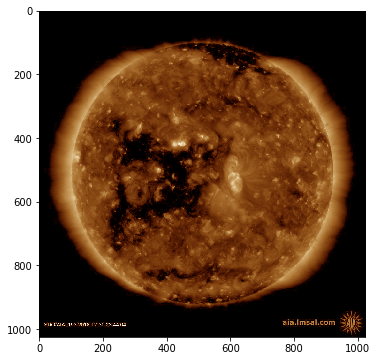

In [6]:
batch.show(10, image='img', cmap=sdoaia193, figsize=(6, 6))

For `abp` files it is recommended to reduce the radius cacluclated by several pixels:

In [7]:
def reduce_r(meta): #recommended correction for abp radius
    meta['r'] -= 3
    return meta

batch.apply_meta(reduce_r, src='img')

#### Disk projection

Next step is to project disk images to Carrington coordinates. Resolution of target synoptic is a free
parameter, here we set it to 720x360:

In [8]:
batch.map_to_synoptic(src='img', dst='syn', bins=(720, 360))

Show the sample projected disk image:

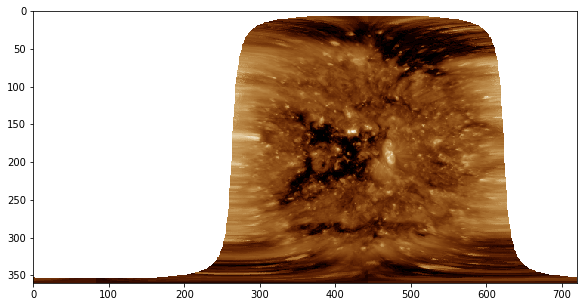

In [9]:
batch.show(10, image='syn', cmap=sdoaia193, figsize=(10, 5))

#### Stacking

Now let's group batch items by rotation numbers (this is out index) and stack them toghether. Given parameters shift and scale are recommended in case of 1 disk image per day:

In [10]:
batch = (batch.group_by_index()
         .stack_synoptic_maps(src='syn', dst='stacked', shift=13.2, scale=2))

Look at the synoptic map so far. Note it appears darker in comparison to disk image:

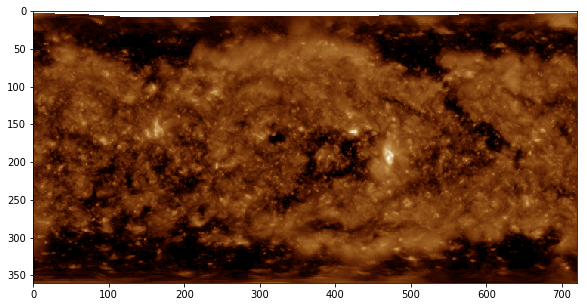

In [11]:
batch.show(0, image='stacked', cmap=sdoaia193, figsize=(10, 5))

Final step is the histogram matching. It helps to get intensity distribution closer to disk images:

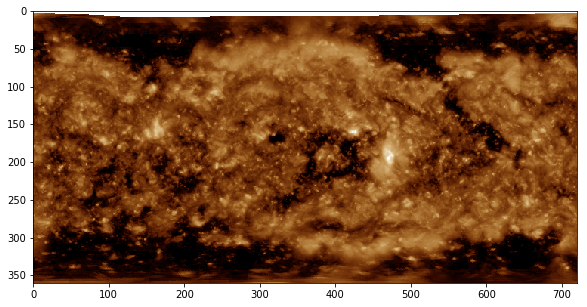

In [12]:
batch.match_histogram(src='stacked', reference='syn')
batch.show(0, image='stacked', cmap=sdoaia193, figsize=(10, 5))

#### Dump

Now there is a variety of formats to save the map to, e.g.

* FITS
``` python
batch.dump(src='stacked', path='./maps/', format='fits', kind='synoptic',
           WAVELNTH=193.0, WAVEUNIT='angstrom', TELESCOP='SDO/AIA',
           INSTRUME='AIA_2')
```
* NPZ
``` python
batch.dump(src='stacked', path='./maps/', format='npz')
```
* JPEG
``` python
batch.dump(src='stacked', path='./maps/', format='jpg', cmap=sdoaia193)
```

For example, save to FITS file:

In [13]:
batch.dump(src='stacked', path='./maps/', format='fits', kind='synoptic',
           WAVELNTH=193.0, WAVEUNIT='angstrom', TELESCOP='SDO/AIA', INSTRUME='AIA_2')

Read and show the file produced:

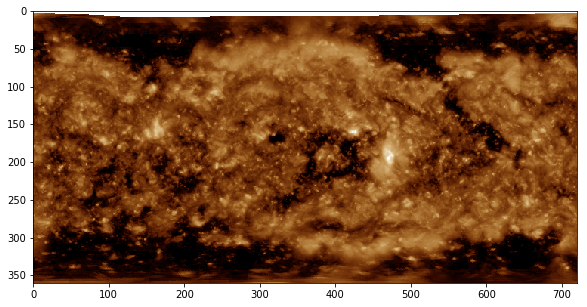

In [14]:
(HelioBatch(FilesIndex(syn='./maps/2212.fits')).load('syn')
 .show(0, image='syn', cmap=sdoaia193, figsize=(10, 5), origin='lower'))

Read and plot the synoptic map with `sunpy.map.Map`:

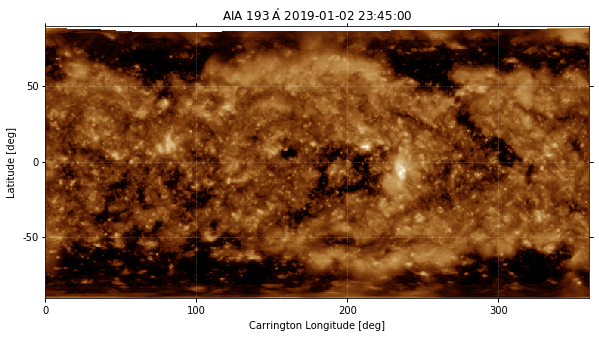

In [15]:
smap = sunpy.map.Map('./maps/2212.fits')

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection=smap)
smap.plot(norm=colors.Normalize())
plt.show()

To process large datasets it is convenient to iterate by batches as given in pipelines:
```python
batch_sampler = BatchSampler(index, batch_size=5)

for ids in tqdm(batch_sampler):
    (HelioBatch(ids).load(...)
     ...
    )
```

### FITS files

Here we explain synoptic maps construction from disk images given in SDO/AIA FITS lev1.5 files.

First we index disk images dataset and compute additional information by parsing date and time of solar disk observation from the filenames. We set index to 'CR' to load data by Carrington rotation numbers:

In [16]:
fits = (FilesIndex(img='../../aia193_fits/aia*.fits')
        .parse_datetime(regex=r'\d{4}[-/]\d{2}[-/]\d{2}[T]\d{6}')
        .get_sun_params()
        .set_index('CR'))
fits.head()

,img,DateTime,L0,B0
CR,,,,
2212,../../aia193_fits\aia.lev1_euv_12s.2018-12-20T...,2018-12-20 23:44:30,353.443492,-1.631964
2212,../../aia193_fits\aia.lev1_euv_12s.2018-12-21T...,2018-12-21 23:44:30,340.269768,-1.756973
2212,../../aia193_fits\aia.lev1_euv_12s.2018-12-22T...,2018-12-22 23:44:30,327.096298,-1.881456
2212,../../aia193_fits\aia.lev1_euv_12s.2018-12-23T...,2018-12-23 23:44:30,313.923101,-2.005373
2212,../../aia193_fits\aia.lev1_euv_12s.2018-12-24T...,2018-12-24 23:44:30,300.750200,-2.128685


Let's load a single Carrington rotation: 

In [17]:
batch = HelioBatch(fits.loc[[2212]]).load('img', as_smap=True, meta='img', unit=1)

FITS files require cetrain calibration before going further. Here we apply calibration from ``aiapy.calibrate`` and adjust intensities to AIA standard:

In [18]:
(batch.correct_degradation(src='img')
 .apply(lambda x: x.data, src='img')
 .aia_intscale(src='img', wavelength=193)
 .flip(src='img', axis=0, update_meta=True))

Hint: if you get `MemoryError` proccessing a single Carrnigton rotation at once, then reindex the dataset by single images and process images in batches of appropriate size.

This is a sample calibrated disk image:

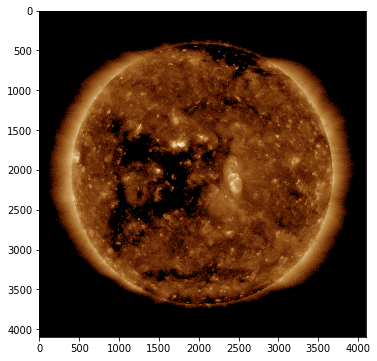

In [19]:
batch.show(10, image='img', cmap=sdoaia193, figsize=(6, 6))

From now on, the process is similar to the previous section. Go to [Disk projection](#Disk-projection) to complete the steps.

Done!